# README

This delivery contains the implementation of the 4th task of the "Automatic Signal Detector" project of the Computer Vision course.
In order to run succesfully, one must download the harcascade from 

*   https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

Import them in their own drive and change the path in the "Synchronizing drive files section"

## Important notes:


1.   The cells that use the webcam run in a loop, one has to **stop manually the cell** and **re-run the notebook from the next cell** to run the rest of the notebook successfully.

# TASK 4 - MACHINE LEARNING AND COMPUTER VISION PROJECT

Author: Nicolás Arrieta Larraza

Date: 12/03/2021

## Initializing

### Importing libraries

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import io
import cv2 # OpenCV library

In [2]:
cv2.__version__

'4.1.2'

### Synchronizing Drive files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Change for custom location
face_cascade_path = "/content/drive/MyDrive/UCA/ComputerVision/task_1/haarcascade_frontalface_default.xml"


### Importing the cascade filter to OpenCV

In [16]:
face_cascades = cv2.CascadeClassifier(face_cascade_path)

## Defining functions

Function to capture video from computer webcam trough the web browser (given)

In [7]:
from google.colab.output import eval_js

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

Functions to convert base64 to bytes array format and viceversa (given). These functions are necessary since the images in Javascript work with base64 format and OpenCV works with bytes array.

In [8]:
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

Function to plot histogram of colors

In [9]:
def show_hist(hist):
  bin_count = hist.shape[0]
  bin_w = 24
  img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
  for i in range(bin_count):
      h = int(hist[i])
      cv2.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  cv2_imshow(img)

Function to compute face recognition

In [10]:
def detect_faces(img, cascades):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = cascades.detectMultiScale(gray, 1.3, 4)
  return faces

Function to scale a rotated box by a factor. It is used to scale up the bounding box to remove the noise in the edges of the rectangle.

In [11]:
def scale_contour(pts, scale_x, scale_y):
    M = cv2.moments(pts)

    if M['m00'] == 0:
      return pts

    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = pts - [cx, cy]
    cnt_scaled = cnt_norm * np.array([scale_x, scale_y])
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

## Capturing region of the recognized faced

First, we need to capture a frame of a face in order to compute it's histogram

In [46]:
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")

  # Detecting faces
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  im_copy = im.copy()
  faces = detect_faces(im, face_cascades)

  # Drawing a green rectangle in face's region
  if len(faces) == 1:
    face = faces[0]
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue
  # Showing capture
  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy)))
  response = input("Use this bounding box? [y or n]:")
  # We offer the user the option to keep the previous frame or redo it
  if response == 'y':
    # In case of accepting we show the selected face frame
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    # Asign it to the tracking window variable that will be use in next steps
    tracking_window_face = face
    break

<IPython.core.display.Javascript object>

Type anything when ready!:a
Use this bounding box? [y or n]:y


## Building histogram from detected face

We compute the histogram of color (only HUE channel) of the face region in order to "back project" it in the entire region. Then we check fro every pixel in the image the probability of its color to be part of the histogram. Therefore, the parts of the body with similar colors will show also high probability like arms, hands, etc.

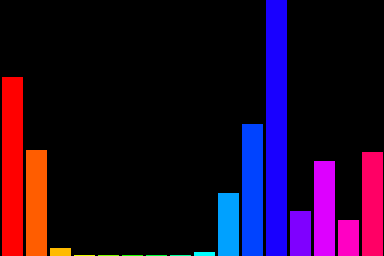

In [47]:
# Transform the previous frame into HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# Creating an inRange mask for pixels
mask = cv2.inRange(hsv,np.array((0,64,32)), np.array((180,200,200)))
# Compute the histogram of the frame (use only the HUE channel). See `https://bit.ly/3pdVUEd`
# Take into account only pixels which are not too bright and not too dark (use the previous mask)
# Use 16 bins and speicfy the range of the hue ([0, 180])
hist = cv2.calcHist([hsv],[0], mask, [16], [0,180])
# Normalize the histogram between 0 (lowest intensity) and 255 (highest intensity) (use MinMax normalization `cv.NORM_MINMAX`) using the method `https://bit.ly/3jMGhCj`
hist = cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
# Reashape the histogram into a 1-D array (use `.reshape(-1)`)
hist = hist.reshape(-1)
# Show the histogram
show_hist(hist)

## Erasing face detection to detect just the hand

In the code below we remove the face detection to focus only on the hand detection. In order to do it we are gonna apply the CAM Shift algorithm to detect the face and erase it by setting probability 0 in the whole bounding box area of the face. Once done, we use CAM Shift again to detect the hand (now it will be the section with more density of probability in the image) and plot a bounding box around it.

It is worth mentioning that this system does not work very well with people with beard since the colors of the beard are dominant in the histogram

In [51]:
VideoCapture()
eval_js('create()')
# Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

byte = eval_js('capture()')
im_width, im_height = im.shape[1],im.shape[0]
im = b64_to_bytes(byte)
 
tracking_window_hand = (0,0,im_width,im_height) # Define the initial tracking window for the hand. It spans the entire caption


while True:
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  # Transform the image into HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  
  # Compute the standard not too bright not too dark mask
  mask = cv2.inRange(hsv, np.array((0., 64., 32.)), np.array((180., 200., 200.)))

  # Back project the histogramm on the hsv img
  prob = cv2.calcBackProject([hsv],[0], hist, [0,180], scale=1)

  # Apply the mask
  prob = prob & mask

  # First look up for the face using cam shift starting from `tracking_window_face`
  (x,y,w,h) = tracking_window_face
  bbox, tracking_window_face = cv2.CamShift(prob, tracking_window_face, term_crit)

  # Retrieve the rotated bounding rectangle
  pts = cv2.boxPoints(bbox).astype(np.int)

  # Scale the rotated bounding box 1.5x times to eliminate detected parts outside the box 
  scaled_pts = scale_contour(pts, 1.5, 1.5)

  # Fill the rotated face bounding box with 0 in the prob map using`cv2.fillPoly`
  cv2.fillPoly(prob, [scaled_pts], 0)

  # Draw the boundix box around the face
  cv2.polylines(im, [scaled_pts], True, (255, 255 , 0), 2)

  # Now look up for the hand using cam shift starting from `tracking_window_hand`
  bbox, tracking_window_hand = cv2.CamShift(prob, tracking_window_hand, term_crit)

  pts = cv2.boxPoints(bbox).astype(np.int)

  # Scale the contour around the hand
  pts = scale_contour(pts, 1.8, 1.5)

  ## Draw the boundix box around the hand
  cv2.polylines(prob, [pts],True,(255, 255 , 0), 2)
  eval_js('showimg("{}")'.format(bytes_to_b64(im)))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored